In [17]:
import csv
import random
import string
import time
import bisect
import matplotlib.pyplot as plt
from pybloom_live import BloomFilter
from cuckoofilter import CuckooFilter

In [18]:
# Step 1: Generate and save synthetic logins dataset
def generate_logins(num_logins, filename='logins.csv', length=10):
    chars = string.ascii_lowercase + string.digits
    logins = set()
    while len(logins) < num_logins:
        login = ''.join(random.choices(chars, k=length))
        logins.add(login)
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['login'])
        for login in logins:
            writer.writerow([login])

# Generate 1 million logins (comment out if dataset already exists)
generate_logins(10_000_000)

# Step 2: Load dataset
def load_logins(filename):
    with open(filename, 'r') as f:
        return [row[0] for row in csv.reader(f)][1:]  # Skip header

logins = load_logins('logins.csv')

# Step 3: Define test parameters
sample_sizes = [100_000, 500_000, 1_000_000, 2_00_000, 5_000_000, 10_000_000]
test_size = 1000  # Number of logins to test per sample size

In [19]:
sample_sizes = [100_000, 500_000, 1_000_000, 2_000_000, 5_000_000, 10_000_000]

In [ ]:
# Step 4: Performance comparison function
def compare_performance(sample_sizes):
    results = {
        'Linear': [],
        'Binary': [],
        'Hash': [],
        'Bloom': [],
        'Cuckoo': []
    }

    for n in sample_sizes:
        print(f"Testing n={n}")
        # Generate test cases (50% existing, 50% non-existing)
        existing = logins[:n//2]
        non_existing = [f"{s}_" for s in existing]  # Guaranteed unique
        test_logins = existing + non_existing
        random.shuffle(test_logins)

        # Linear Search
        if n <= 1_000_000:  # Limit due to time constraints
            start = time.time()
            for login in test_logins:
                login in logins
            results['Linear'].append(time.time() - start)
        else:
            results['Linear'].append(None)

        # Binary Search
        sorted_subset = sorted(logins)
        start = time.time()
        for login in test_logins:
            idx = bisect.bisect_left(sorted_subset, login)
            found = idx < len(sorted_subset) and sorted_subset[idx] == login
        results['Binary'].append(time.time() - start)

        # Hash Table
        hash_set = set(logins)
        start = time.time()
        for login in test_logins:
            login in hash_set
        results['Hash'].append(time.time() - start)

        # Bloom Filter
        bf = BloomFilter(capacity=n, error_rate=0.001)
        for login in logins:
            bf.add(login)
        start = time.time()
        for login in test_logins:
            bf.__contains__(login)
        results['Bloom'].append(time.time() - start)

        # Cuckoo Filter
        cf = CuckooFilter(capacity=n, fingerprint_size=8)
        for login in logins:
            cf.insert(login)
        start = time.time()
        for login in test_logins:
            cf.contains(login)
        results['Cuckoo'].append(time.time() - start)

    return results

# Run performance tests
results = compare_performance(sample_sizes)

Testing n=100000


In [21]:
results

{'Linear': [0.8284881114959717,
  3.9662301540374756,
  6.8722827434539795,
  None,
  None,
  None],
 'Binary': [0.0010020732879638672,
  0.0009989738464355469,
  0.0009996891021728516,
  0.0010001659393310547,
  0.0019998550415039062,
  0.0019986629486083984],
 'Hash': [0.0010006427764892578, 0.0, 0.0, 0.0, 0.0, 0.0],
 'Bloom': [0.001997709274291992,
  0.0019998550415039062,
  0.002000093460083008,
  0.0020008087158203125,
  0.0029993057250976562,
  0.002000570297241211],
 'Cuckoo': [0.002001523971557617,
  0.0030002593994140625,
  0.002000093460083008,
  0.0019979476928710938,
  0.0019986629486083984,
  0.003000020980834961]}

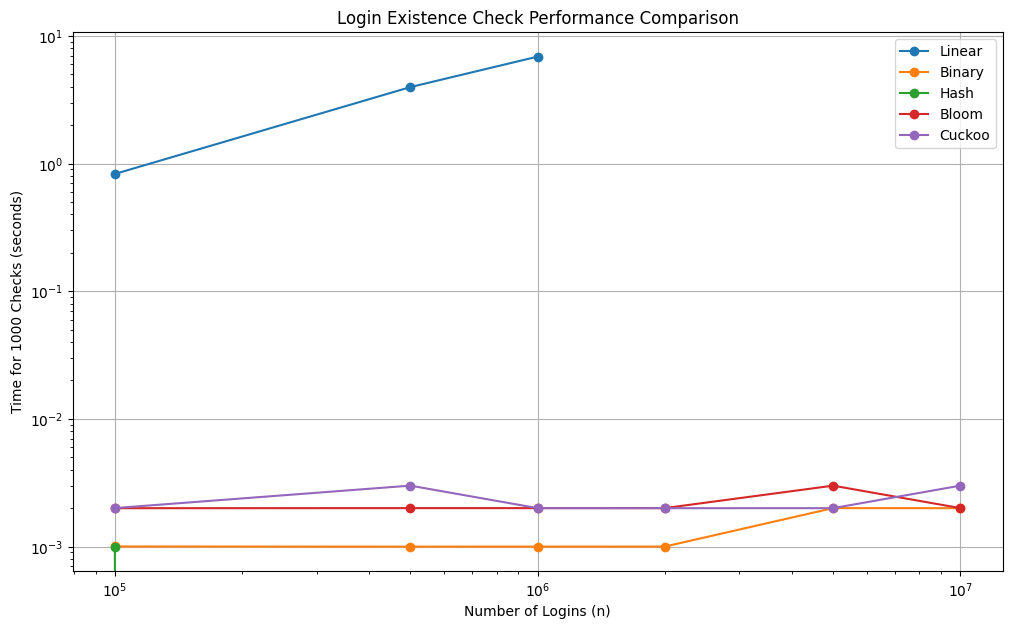

In [22]:
# Step 5: Plot results
plt.figure(figsize=(12, 7))
for method in results:
    valid_sizes = [n for n, t in zip(sample_sizes, results[method]) if t is not None]
    valid_times = [t for t in results[method] if t is not None]
    plt.plot(valid_sizes, valid_times, marker='o', label=method)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Logins (n)')
plt.ylabel(f'Time for {test_size} Checks (seconds)')
plt.title('Login Existence Check Performance Comparison')
plt.legend()
plt.grid(True)
plt.savefig('runtime_complexity.png')
plt.show()